In [1]:
import pandas as pd
results_file_name = 'results.csv'
results = pd.read_csv(results_file_name)

races_file_name = 'races.csv'
races = pd.read_csv(races_file_name)

results = results.join(races.set_index('race_id'), on = 'race_id')
results = results.loc[results.rider != 'no result']

results['rider_id'] = results.rider.astype('category').cat.codes
results['race'] = results.race_id.astype('category').cat.codes
rider_lookup = results[['rider', 'rider_id']].drop_duplicates().set_index('rider_id')
race_lookup = results[['name', 'race']].drop_duplicates().set_index('race')

results['cq_points'] = results['cq_points'] / max(results['cq_points'])

results

,rank,rider,team,time,cq_points,race_id,start,end,cat,name,rider_id,race
0,1.0,LONARDI Giovanni,EOK,"4h23'11""",0.053571,39288,23/01/2022,NaN,1.2,GP Valencia,858,0
1,2.0,CAPIOT Amaury,ARK,NaN,0.035714,39288,23/01/2022,NaN,1.2,GP Valencia,234,0
2,3.0,LAWLESS Christopher,TEN,NaN,0.028571,39288,23/01/2022,NaN,1.2,GP Valencia,824,0
3,4.0,JAIME FERNANDEZ Alex,EKP,"02""",0.025000,39288,23/01/2022,NaN,1.2,GP Valencia,686,0
4,5.0,SOTO GUIRAO Antonio Jesus,EUS,"02""",0.021429,39288,23/01/2022,NaN,1.2,GP Valencia,1334,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4922,16.0,ALMAMMARI Faisal,-,"06'35""",0.000000,40839,23/12/2022,NaN,1.2,"Arab Road Cycling Championships (Kalba, Sharjah)",31,186
4923,17.0,ALMARHOON Hani,-,"07'19""",0.000000,40839,23/12/2022,NaN,1.2,"Arab Road Cycling Championships (Kalba, Sharjah)",34,186
4924,18.0,ALRAHBI Said,-,"07'19""",0.000000,40839,23/12/2022,NaN,1.2,"Arab Road Cycling Championships (Kalba, Sharjah)",38,186
4925,19.0,ALRIKABI Ahmed,-,"08'45""",0.000000,40839,23/12/2022,NaN,1.2,"Arab Road Cycling Championships (Kalba, Sharjah)",39,186


In [3]:
from tensorflow.keras.layers import TextVectorization, Flatten, Embedding, Dot, ReLU
from tensorflow.keras import Input, Model
from tensorflow.keras.activations import relu

rider = Input(shape = (1,), dtype = 'int32', name = 'rider')
race = Input(shape = (1,), dtype = 'int32', name = 'race')

EMBEDDING_DIMENSION = 5
rider_encoder = ReLU()(Flatten()(
    Embedding(input_dim = max(results.rider_id) + 1, output_dim = EMBEDDING_DIMENSION, name = 'rider_encoder')(rider)))
race_encoder = ReLU()(Flatten()(
    Embedding(input_dim = max(results.race) + 1, output_dim = EMBEDDING_DIMENSION, name = 'race_encoder')(race)))

dot_product = Dot(axes = (1, 1), name = 'dot_product')([rider_encoder, race_encoder])
output = relu(dot_product)

model = Model([rider, race], output)

model.compile(optimizer = "adam", loss = "mean_squared_error")

history = model.fit([results.rider_id, results.race], results.cq_points, epochs=100, verbose = 0)
results['pred'] = model.predict([results.rider_id, results.race]).round(4)
results.sort_values('pred', ascending = False).head(15)

2023-01-28 11:05:48.551347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


154/154 [==============================] - 0s 794us/step


,rank,rider,team,time,cq_points,race_id,start,end,cat,name,rider_id,race,pred
1506,1.0,VAN DER POEL Mathieu,ADC,"6h18'30""",1.000000,39692,3/04/2022,NaN,1.WT1,Ronde van Vlaanderen,1474,56,1.0058
1824,1.0,EVENEPOEL Remco,QST,"6h12'38""",1.000000,39708,24/04/2022,NaN,1.WT1,Liège - Bastogne - Liège,440,67,0.9979
1742,1.0,VAN BAARLE Dylan,IGD,"5h37'00""",1.000000,39702,17/04/2022,NaN,1.WT1,Paris - Roubaix,1461,64,0.9804
4453,1.0,POGACAR Tadej,UAD,"6h21'22""",1.000000,40721,8/10/2022,NaN,1.WT1,Il Lombardia,1135,173,0.9040
1238,1.0,VAN AERT Wout,TJV,"4h38'04""",0.785714,39431,25/03/2022,NaN,1.WT2,E3 Harelbeke,1458,47,0.7988
3040,1.0,EVENEPOEL Remco,QST,"5h31'44""",0.785714,40325,30/07/2022,NaN,1.WT2,Clasica San Sebastian,440,124,0.7789
1773,1.0,TEUNS Dylan,TBV,"4h42'12""",0.785714,39705,20/04/2022,NaN,1.WT2,Flèche Wallonne,1399,65,0.7593
1567,1.0,KWIATKOWSKI Michal,IGD,"6h01'19""",0.785714,39695,10/04/2022,NaN,1.WT2,Amstel Gold Race,793,58,0.6616
1269,1.0,GIRMAY HAILU Biniam,IWG,"5h37'57""",0.785714,39438,27/03/2022,NaN,1.WT2,Gent - Wevelgem,543,48,0.6555
1382,1.0,VAN DER POEL Mathieu,ADC,"4h05'39""",0.642857,39446,30/03/2022,NaN,1.WT3,Dwars door Vlaanderen,1474,52,0.6212


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rider (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 race (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 rider_encoder (Embedding)      (None, 1, 5)         8215        ['rider[0][0]']                  
                                                                                                  
 race_encoder (Embedding)       (None, 1, 5)         935         ['race[0][0]']                   
                                                                                              

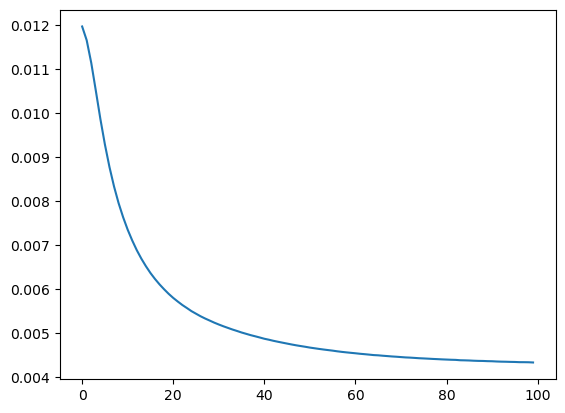

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [6]:
results.query('race == 173').sort_values('pred', ascending = False)

,rank,rider,team,time,cq_points,race_id,start,end,cat,name,rider_id,race,pred
4453,1.0,POGACAR Tadej,UAD,"6h21'22""",1.000000,40721,8/10/2022,NaN,1.WT1,Il Lombardia,1135,173,0.9040
4455,3.0,LANDA MEANA Mikel,TBV,"10""",0.517857,40721,8/10/2022,NaN,1.WT1,Il Lombardia,807,173,0.5181
4454,2.0,MAS NICOLAU Enric,MOV,NaN,0.607143,40721,8/10/2022,NaN,1.WT1,Il Lombardia,928,173,0.5126
4456,4.0,HIGUITA GARCIA Sergio Andres,BOH,"52""",0.446429,40721,8/10/2022,NaN,1.WT1,Il Lombardia,640,173,0.5015
4457,5.0,RODRIGUEZ CANO Carlos,IGD,"52""",0.400000,40721,8/10/2022,NaN,1.WT1,Il Lombardia,1220,173,0.3450
4458,6.0,VALVERDE BELMONTE Alejandro,MOV,"01'24""",0.357143,40721,8/10/2022,NaN,1.WT1,Il Lombardia,1457,173,0.3262
4469,17.0,MARTINEZ POVEDA Daniel Felipe,IGD,"02'14""",0.107143,40721,8/10/2022,NaN,1.WT1,Il Lombardia,925,173,0.3249
4468,16.0,VINGEGAARD RASMUSSEN Jonas,TJV,"02'03""",0.114286,40721,8/10/2022,NaN,1.WT1,Il Lombardia,1556,173,0.2842
4460,8.0,MOLARD Rudy,GFC,"01'24""",0.285714,40721,8/10/2022,NaN,1.WT1,Il Lombardia,973,173,0.2697
4459,7.0,MOLLEMA Bauke,TFS,"01'24""",0.321429,40721,8/10/2022,NaN,1.WT1,Il Lombardia,975,173,0.2559


In [7]:
from sklearn.metrics import pairwise_distances

rider_similarities = pairwise_distances(model.get_layer('rider_encoder').get_weights()[0], metric = 'cosine')
rider_similarities = (
    pd.DataFrame(rider_similarities)
    .stack()
    .reset_index()
    .rename(columns = {'level_0': 'rider_1', 'level_1': 'rider_2', 0: 'similarity'})
    .query('rider_1 < rider_2')
    .join(rider_lookup, on = 'rider_1')
    .rename(columns = {'rider': 'rider_1'})
    .join(rider_lookup, on = 'rider_2')
    .rename(columns = {'rider': 'rider_2'})
)
rider_similarities.sort_values('similarity', ascending = False).head(10)

,rider_1,rider_2,similarity,rider_1,rider_2
788063,479,1066,1.998984,FORMOLO Davide,OURSELIN Paul
2048429,1246,1251,1.998332,RYE-JOHNSEN Jon,SABBAHI Lahcen
407172,247,1351,1.998038,CARVALHO Gonçalo Henrique Matos,STEININGER Fabian
1994214,1213,1255,1.997990,RIVERA VARGAS Brandon Smith,SAIDI Nassim
803326,488,1542,1.997551,FREITAS Daniel Alexandre Loureiro Silva,VERMOTE Julien
2181761,1327,1500,1.996930,SMITH Dion,VAN SINTMAARTENSDIJK Roel
702198,427,637,1.996745,EL KOURAJI Mohcine,HESSEL Kristian
1338729,814,1327,1.996439,LARSEN Niklas,SMITH Dion
788600,479,1603,1.996423,FORMOLO Davide,WOLF Justin
1828333,1112,1317,1.996289,PETR Ondrej,SIVAKOV Pavel


In [8]:
from sklearn.metrics import pairwise_distances

race_similarities = pairwise_distances(model.get_layer('race_encoder').get_weights()[0], metric = 'cosine')
race_similarities = (
    pd.DataFrame(race_similarities)
    .stack()
    .reset_index()
    .rename(columns = {'level_0': 'race_1', 'level_1': 'race_2', 0: 'similarity'})
    .query('race_1 < race_2')
    .join(race_lookup, on = 'race_1')
    .rename(columns = {'name': 'race_1'})
    .join(race_lookup, on = 'race_2')
    .rename(columns = {'name': 'race_2'})
)
race_similarities.sort_values('similarity', ascending = False).head(10)

,race_1,race_2,similarity,race_1,race_2
7388,39,95,1.947338,Rhodes GP,Giro dell'Appennino
23559,125,184,1.944893,Circuito de Getxo,Caribbean Championships (Santo Domingo) I.T.T.
23533,125,158,1.944183,Circuito de Getxo,Omloop van het Houtland - Lichtervelde
7383,39,90,1.943516,Rhodes GP,Marcel Kint Classic
6584,35,39,1.937320,GP Manavgat Side,Rhodes GP
22385,119,132,1.936177,GP Kranj,Bemer Cyclassics - Hamburg
7437,39,144,1.930411,Rhodes GP,Circuit Franco-Belge
7406,39,113,1.928556,Rhodes GP,Trofeo Citta di Brescia
10223,54,125,1.921959,GP Miguel Indurain,Circuito de Getxo
9686,51,149,1.917927,GP Industria & Artigianato - Larciano,GP de Montréal


In [19]:
model.get_layer('rider_encoder').weights[0]

<tf.Variable 'rider_encoder/embeddings:0' shape=(1643, 5) dtype=float32, numpy=
array([[ 5.0145499e-03, -3.6715388e-02, -1.5907629e-03, -4.0058840e-02,
        -4.0910617e-03],
       [ 2.0873755e-02,  5.6363817e-02, -2.7828027e-02,  1.0114850e-01,
        -9.0139511e-04],
       [-1.1861240e-02, -4.0829338e-02, -3.3518195e-02, -1.2821516e-06,
        -4.3682259e-04],
       ...,
       [-1.8683560e-03, -4.0691435e-02, -3.1635962e-02,  6.1082952e-03,
        -3.6046052e-04],
       [-1.9078124e-02, -1.5226633e-03, -3.5288911e-03, -5.8737784e-05,
        -7.3722638e-03],
       [-7.1755536e-03, -3.7645899e-02,  1.5396271e-02, -3.6225140e-02,
        -2.5662696e-02]], dtype=float32)>

Next steps:
- Stages/stage races
- Add preprocessing as layers
- Nonnegative constraint for embeddings - causes error...
- Test set evaluation (by race, window vs random)
- Unobserved rider/race (e.g. predict Il Lombardia on all riders)
- Multiple random initializations